## Table of Content:
* [Data Preparation & Visualisation](#data-prep-viz)
* [Machine Learning](#ml)

In [210]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from skimpy import skim

In [211]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preparation & Visualisation <a class="anchor" id="data-prep-viz"></a>

## Helper Functions

In [212]:
NUMPY_INTS = [numpy.dtypes.Float64DType,numpy.dtypes.Float32DType, numpy.dtypes.Int64DType, numpy.dtypes.Int32DType]

def fetch_data(url, out_file):
  res = requests.get(url)
  if res.content:
    with open(out_file, "w") as csv_file:
      writer = csv.writer(csv_file)
      content = res.content.decode("utf-8").split("\n")
      for line in content:
        line = [entry.replace('"', '').replace('\r', '') for entry in line.split(",")]
        writer.writerow(line)

# Returns a cleaned up dataframe
def do_basic_cleanup(df, drop_cols):
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    return df

# returns a series with Value counts, where ....
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
def value_counts(df):
    res = []
    for col in df.columns:
      preliminary_res = df[col].value_counts()
      if preliminary_res.size > 20:
        if type(df[col].dtype) in NUMPY_INTS:
          preliminary_res = df[col].value_counts(bins=10)
          preliminary_res.name = preliminary_res.name + "- BINNED"
        else:
          preliminary_res = df[col].value_counts(normalize=True)  
          preliminary_res.name = preliminary_res.name + "- NORMALIZED"
      res.append(preliminary_res)
    return res

def cast_cols_to_str(df, cols):
    for col in cols:
      df[col] = df[col].astype(str)


In [213]:
# Source: https://data.cso.ie/table/ASA02
fetch_data("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ASA02/CSV/1.0/en", "irl_tourism.csv")

In [437]:
df = pd.read_csv("irl_tourism.csv", on_bad_lines='warn')
df.head(10)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02293V02763,Direction,C03042V03675,Route,UNIT,VALUE
0,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,-,All routes of travel,Thousand,12902.2
1,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,01,Cross channel,Thousand,6113.0
2,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,02,Continental Europe,Thousand,5652.6
3,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,03,Transatlantic,Thousand,914.5
4,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,04,Other,Thousand,222.1
5,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,-,All routes of travel,Thousand,12920.2
6,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,01,Cross channel,Thousand,6132.4
7,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,02,Continental Europe,Thousand,5643.3
8,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,03,Transatlantic,Thousand,924.3
9,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,04,Other,Thousand,220.3


In [215]:
df = do_basic_cleanup(df, ["STATISTIC", "STATISTIC Label", "TLIST(A1)", "C02293V02763", "C03042V03675", "UNIT"])

df = df.dropna()
df = df.astype({"year": int})
df.head()

,year,direction,route,value
0,2010,Arrivals,All routes of travel,12902.2
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1


,year,direction,route,value
135,2023,Departures,All routes of travel,20626.2
136,2023,Departures,Cross channel,7216.1
137,2023,Departures,Continental Europe,10485.0
138,2023,Departures,Transatlantic,2139.5
139,2023,Departures,Other,785.6


In [216]:
#df.apply(lambda col: col.value_counts(), axis=1)
#skim(df)
df['value'].value_counts(bins=7)
print(type(df['value'].dtype))

(128.722, 3074.486]       64
(5999.771, 8925.057]      33
(3074.486, 5999.771]      12
(11850.343, 14775.629]    10
(17700.914, 20626.2]       8
(8925.057, 11850.343]      7
(14775.629, 17700.914]     6
Name: count, dtype: int64

<class 'numpy.dtypes.Float64DType'>


## Looking at arrivals from different destinations 

In [217]:
arrivals = df[(df['direction'] == 'Arrivals') & (df['route'] != 'All routes of travel')]
departures = df[(df['direction'] == 'Departures') & (df['route'] != 'All routes of travel')]

In [218]:
arrivals.head()

,year,direction,route,value
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1
11,2011,Arrivals,Cross channel,6102.5


Text(0.5, 1.0, 'Number of Arrivals Into Ireland')

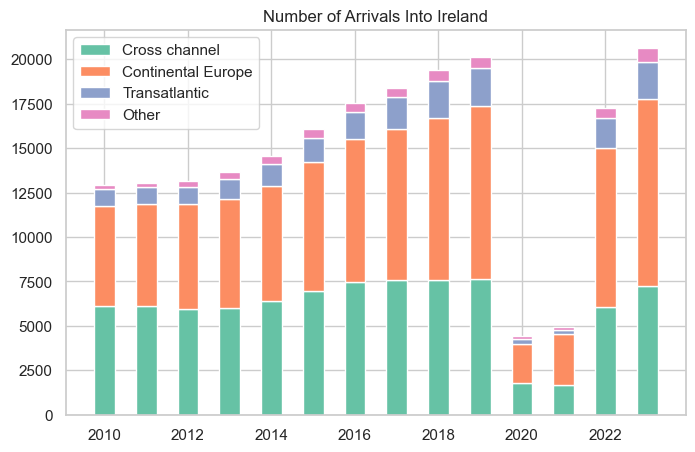

In [219]:
#sns.set_theme(style="whitegrid")

#ax = sns.barplot(data=arrivals, x="year", y="value", hue="route", palette='flare')

x = arrivals['year'].unique()
routes = arrivals['route'].unique()
bottom = np.zeros(len(x))
palette = sns.color_palette("Set2")

_, ax= plt.subplots(figsize=(8, 5))
width = 0.5

#for year in x:
for i, route in enumerate(routes):
   data = arrivals[arrivals['route'] == route]['value']
   _ = ax.bar(x, data, width, label=route, bottom=bottom, color=palette[i])
   bottom += data.to_numpy()

ax.set_title("Number of Arrivals Into Ireland")
ax.legend(loc="upper left")


## Explore percent change Year over Year

In [222]:
arrivals_cols = arrivals.set_index(['year', 'route'])['value'].unstack()
raw_cols = arrivals_cols.columns
new_cols = []
for c in arrivals_cols.columns.to_numpy():
    new_col = "ptc_ch_" + c.lower().replace(" ", "_")
    new_cols.append(new_col)
    arrivals_cols[new_col] = round(arrivals_cols[c].pct_change() * 100, 2)
arrivals_cols = arrivals_cols.drop(columns=raw_cols)
arrivals_cols = arrivals_cols.reset_index()
arrivals_cols.head()

route,year,ptc_ch_continental_europe,ptc_ch_cross_channel,ptc_ch_other,ptc_ch_transatlantic
0,2010,NaN,NaN,NaN,NaN
1,2011,2.30,-0.17,4.55,1.97
2,2012,2.38,-2.82,43.84,2.68
3,2013,3.72,1.44,14.85,14.16
4,2014,5.09,6.75,12.96,13.31


In [223]:
a = arrivals_cols.melt(id_vars=['year'], value_vars=new_cols)
a.head()

,year,route,value
0,2010,ptc_ch_continental_europe,NaN
1,2011,ptc_ch_continental_europe,2.30
2,2012,ptc_ch_continental_europe,2.38
3,2013,ptc_ch_continental_europe,3.72
4,2014,ptc_ch_continental_europe,5.09


<Axes: xlabel='year', ylabel='value'>

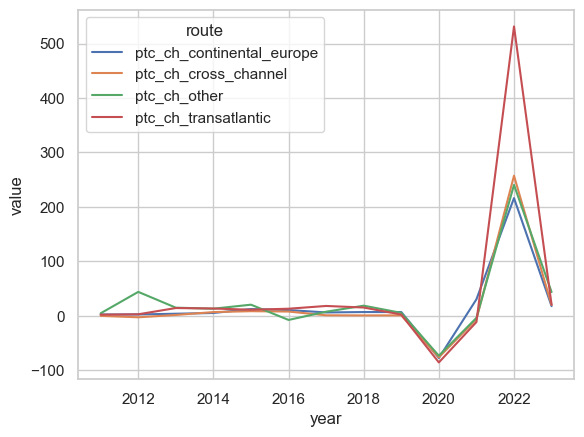

In [398]:
sns.lineplot(data=a, x="year", y="value", hue="route")

## Flights to Ireland from other international airports
1. Data from https://ec.europa.eu/eurostat/web/transport/data/database
2. https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=avia.avia_pa.avia_par&display=list&sort=category&extractionId=avia_par_ie
3. Explanatory notes on the data https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en
4. API https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true

|Dimension	| Agency : Code list | Values |
| --- | --- | --- |
|FREQ | Time frequency	ESTAT : FREQ | Annual, Quarterly, Monthly ||
|UNIT | Unit of measure	ESTAT : UNIT | Passenger, Flights, Seats and berths||
|TRA_MEAS | Traffic and transport measurement	ESTAT : TRA_MEAS ||
|AIRP_PR | Airport pairs (routes)	ESTAT : AIRP_PR ||
|OBS_FLAG | Observation status (Flag)	ESTAT : OBS_FLAG ||

In [226]:
#IRL_AIRPORT_PASS_TRAVEL = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true"
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=SDMX-CSV&lang=en&label=both
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=TSV
# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

### ONLY REPLAY IF DATASET IS MISSING< IT IS VERY BIG
fetch_data("https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/avia_par_ie/1.0?compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name", 
           "flights.csv")

In [527]:
# Cannot commit the dataset to GitHub, as it is beyond the file size allowd by GH
# Replay the previous step to generate the dataset
# low_memory=False due to mixed datatypes
flights = pd.read_csv("flights.csv", low_memory=False)

In [528]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)
#flights.columns
flights.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,airp_pr,Airport pairs (routes),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag)
0,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2012,NaN,256.0,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2013,NaN,248.0,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CH_LSZH,CORK airport - ZURICH airport,2019,NaN,213.0,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2003,NaN,296.0,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2004,NaN,557.0,NaN,NaN,NaN


In [529]:
# Remove column repetitions
flights = do_basic_cleanup(flights, ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", 
                                     "freq", 'unit', 'Time', 'Observation value', 'Observation status (Flag)', 'OBS_FLAG', 'tra_meas', 'Airport pairs (routes)'])

In [530]:
flights.dtypes
value_counts(flights)

time_frequency                        object
unit_of_measure                       object
traffic_and_transport_measurement     object
airp_pr                               object
time_period                           object
obs_value                            float64
dtype: object

[time_frequency
 Monthly      370798
 Quarterly    126827
 Annual        31623
 Name: count, dtype: int64,
 unit_of_measure
 Passenger           270142
 Seats and berths    129621
 Flight              129485
 Name: count, dtype: int64,
 traffic_and_transport_measurement
 Passengers carried                               46912
 Passengers carried (arrival)                     46826
 Passengers carried (departures)                  46783
 Passengers on board                              43279
 Passengers seats available                       43279
 Commercial passenger air flights                 43228
 Passengers on board (arrivals)                   43188
 Passengers seats available (arrivals)            43188
 Passengers on board (departures)                 43154
 Passengers seats available (departures)          43154
 Commercial passenger air flights (arrivals)      43143
 Commercial passenger air flights (departures)    43114
 Name: count, dtype: int64,
 airp_pr
 IE_EIDW_UK_EGSS    

In [531]:
flights_m = flights[flights['time_frequency'] == 'Monthly']

In [532]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True
flights_m[['year', 'month']] = flights_m['time_period'].str.split('-', expand=True)
flights_m = flights_m.drop(columns=['time_period', 'time_frequency'])

In [533]:
flights_m.head()

,unit_of_measure,traffic_and_transport_measurement,airp_pr,obs_value,year,month
31623,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,6.0,2012,03
31624,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,04
31625,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,05
31626,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,06
31627,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,07


In [534]:
#flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
#flights_m[['domestic_airpot', 'international_airport']] 
flights_m['airp_pr'].apply(lambda x: len(x)).value_counts()

# Same lengths, so we can attempt to split the pairs
flights_m['domestic_airpot']  = flights_m['airp_pr'].apply(lambda x: x[:7])
flights_m['international_airport'] = flights_m['airp_pr'].apply(lambda x: x[8:15])
flights_m.drop(columns=['airp_pr'], inplace=True)

flights_m['domestic_airpot'].value_counts()
flights_m['international_airport'].value_counts()

airp_pr
15    370798
Name: count, dtype: int64

domestic_airpot
IE_EIDW    217466
IE_EICK     60768
IE_EINN     54716
IE_EIKN     22844
IE_EIKY     12016
IE_EICM      2988
Name: count, dtype: int64

international_airport
UK_EGSS    14119
UK_EGCC    12208
UK_EGKK    10485
UK_EGBB    10410
ES_GCRR     9855
UK_EGLL     9065
UK_EGGW     9034
UK_EGGP     8863
UK_EGPH     8832
PT_LPFR     8801
ES_LEMG     8439
ES_LEAL     7381
UK_EGGD     7200
FR_LFPG     6448
UK_EGNX     6299
NL_EHAM     6261
PL_EPWR     6048
US_KJFK     5814
IE_EIDW     5808
US_KEWR     5699
ES_LEPA     5609
US_KBOS     5461
ES_GCLP     5190
ES_GCTS     4872
ES_LEBL     4720
FR_LFOB     4661
UK_EGPF     4524
PL_EPKK     4356
US_KORD     4032
DE_EDDM     3990
IT_LIRF     3728
CZ_LKPR     3537
DE_EDDB     3432
BE_EBBR     3405
DE_EDFH     3323
UK_EGNM     3240
UK_EGNT     3200
IT_LIME     3192
HU_LHBP     3192
BE_EBCI     3159
DE_EDDF     3102
DK_EKCH     3044
ES_LEMD     3036
UK_EGLC     3024
LT_EYKA     3000
ES_LERS     3000
CH_LSZH     2988
FR_LFMN     2856
US_KATL     2848
US_KPHL     2821
UK_EGPK     2820
DE_EDDL     2820
AT_LOWW     2784
PL_EPGD     2712
PT_LPPT     2712
PL_EPMO     2640
UK_EGHI     2592
LV_EVRA  

In [535]:
flights_m.head()

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport
31623,Flight,Commercial passenger air flights,6.0,2012,03,IE_EICK,BE_EBBR
31624,Flight,Commercial passenger air flights,26.0,2012,04,IE_EICK,BE_EBBR
31625,Flight,Commercial passenger air flights,26.0,2012,05,IE_EICK,BE_EBBR
31626,Flight,Commercial passenger air flights,26.0,2012,06,IE_EICK,BE_EBBR
31627,Flight,Commercial passenger air flights,26.0,2012,07,IE_EICK,BE_EBBR


In [508]:
# res = requests.get('https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/3b2e5355eb49336f0c6bc0060c05d927c2d1e004/ISO3166-1.alpha2.json')
# take this maybe?

res = requests.get('https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.json')
country_codes = json.loads(res.content.decode("utf-8"))

In [509]:
country_codes

{'AD': {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'AD',
  'country_code3': 'AND',
  'country_name': 'Andorra',
  'country_name_full': 'Principality of Andorra',
  'iso3': '020'},
 'AE': {'continent_code': 'AS',
  'continent_name': 'Asia',
  'country_code2': 'AE',
  'country_code3': 'ARE',
  'country_name': 'United Arab Emirates',
  'country_name_full': 'United Arab Emirates',
  'iso3': '784'},
 'AF': {'continent_code': 'AS',
  'continent_name': 'Asia',
  'country_code2': 'AF',
  'country_code3': 'AFG',
  'country_name': 'Afghanistan',
  'country_name_full': 'Islamic Republic of Afghanistan',
  'iso3': '004'},
 'AG': {'continent_code': 'NA',
  'continent_name': 'North America',
  'country_code2': 'AG',
  'country_code3': 'ATG',
  'country_name': 'Antigua and Barbuda',
  'country_name_full': 'Antigua and Barbuda',
  'iso3': '028'},
 'AI': {'continent_code': 'NA',
  'continent_name': 'North America',
  'country_code2': 'AI',
  'country_code3': 'AIA',
  'coun

In [510]:
# According to https://www.destatis.de/Europa/EN/Country/Country-Codes.html Greece is assigned GR country code, however, on Eurostate it is EL
# In our countries mapping, we only have GR, so we can add an entry for Greece in our `country_codes`
# GB (Eurostat: UK)
# Add aliases for EL and UK, which are actually GR and GB

country_codes['EL'] = {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'GR',
  'country_code3': 'GRC',
  'country_name': 'Greece'}

country_codes['UK'] = {   "continent_code": "EU",
    "continent_name": "Europe",
    "country_code2": "GB",
    "country_code3": "GBR",
    "country_name": "United Kingdom of Great Britain & Northern Ireland",
    "country_name_full": "United Kingdom of Great Britain & Northern Ireland",
    "iso3": "826"
  }

In [536]:
flights_m['country_code'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['country_name'] if x[0:2] in country_codes else x[0:2])

flights_m['continent_name'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['continent_name'] if x[0:2] in country_codes else x[0:2])

flights_m = flights_m.loc[(flights_m['continent_name'] == 'Europe')]
flights_m['obs_value'] = flights_m['obs_value'].astype(int)

In [554]:
passengers_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (arrivals)')]
passengers_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (departures)')]

seats_available_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Seats and berths') & (flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (arrivals)')]
seats_available_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Seats and berths') & (flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (departures)')]

flights_arr_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (arrivals)')]
flights_dep_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (departures)')]

#flights_pass_q = flights_pass_q.drop(columns=['time_frequency', 'unit_of_measure', 'traffic_and_transport_measurement', 'tra_meas', 'obs_flag'])
# flights_pass_q.head()
# flights_pass_q.size
# https://store.icao.int/en/location-indicators-doc-7910 to map to 


<Axes: xlabel='month', ylabel='obs_value'>

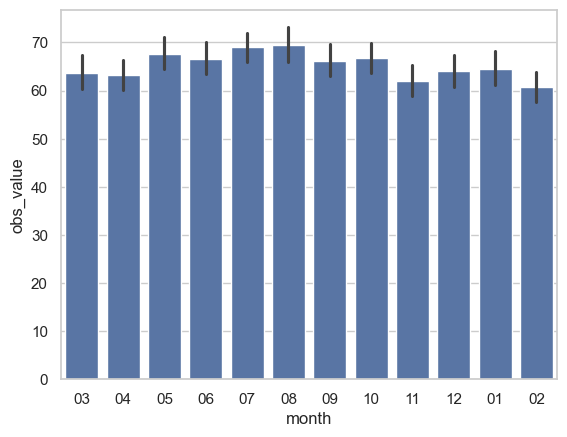

In [518]:
sns.barplot(data=flights_dep_month, x='month', y='obs_value')

In [555]:
component_dfs = [passengers_arr_month, passengers_dep_month, flights_arr_month, flights_dep_month, seats_available_arr_month, seats_available_dep_month]

for df in component_dfs:
  df.head()

for df in component_dfs:
  df.shape

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
152840,Passenger,Passengers on board (arrivals),271,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
152841,Passenger,Passengers on board (arrivals),1346,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
152842,Passenger,Passengers on board (arrivals),1377,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
152843,Passenger,Passengers on board (arrivals),1082,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
152844,Passenger,Passengers on board (arrivals),1550,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
183148,Passenger,Passengers on board (departures),307,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
183149,Passenger,Passengers on board (departures),1321,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
183150,Passenger,Passengers on board (departures),1344,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
183151,Passenger,Passengers on board (departures),1152,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
183152,Passenger,Passengers on board (departures),1383,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
61956,Flight,Commercial passenger air flights (arrivals),3,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
61957,Flight,Commercial passenger air flights (arrivals),13,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
61958,Flight,Commercial passenger air flights (arrivals),13,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
61959,Flight,Commercial passenger air flights (arrivals),13,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
61960,Flight,Commercial passenger air flights (arrivals),13,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
92225,Flight,Commercial passenger air flights (departures),3,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
92226,Flight,Commercial passenger air flights (departures),13,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
92227,Flight,Commercial passenger air flights (departures),13,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
92228,Flight,Commercial passenger air flights (departures),13,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
92229,Flight,Commercial passenger air flights (departures),13,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
341842,Seats and berths,Passengers seats available (arrivals),522,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
341843,Seats and berths,Passengers seats available (arrivals),2262,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
341844,Seats and berths,Passengers seats available (arrivals),2262,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
341845,Seats and berths,Passengers seats available (arrivals),2262,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
341846,Seats and berths,Passengers seats available (arrivals),2262,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport,country_code,continent_name
372150,Seats and berths,Passengers seats available (departures),522,2012,03,IE_EICK,BE_EBBR,Belgium,Europe
372151,Seats and berths,Passengers seats available (departures),2262,2012,04,IE_EICK,BE_EBBR,Belgium,Europe
372152,Seats and berths,Passengers seats available (departures),2262,2012,05,IE_EICK,BE_EBBR,Belgium,Europe
372153,Seats and berths,Passengers seats available (departures),2262,2012,06,IE_EICK,BE_EBBR,Belgium,Europe
372154,Seats and berths,Passengers seats available (departures),2262,2012,07,IE_EICK,BE_EBBR,Belgium,Europe


(26865, 9)

(26837, 9)

(26850, 9)

(26817, 9)

(26865, 9)

(26837, 9)

In [556]:
passengers_arr_month.rename(columns={"obs_value": "num_passangers_arrivals"}, inplace=True)
passengers_dep_month.rename(columns={"obs_value": "num_passangers_departures"}, inplace=True)

seats_available_arr_month.rename(columns={"obs_value": "total_capacity_arrivals"}, inplace=True)
seats_available_dep_month.rename(columns={"obs_value": "total_capacity_departures"}, inplace=True)

flights_arr_month.rename(columns={"obs_value": "num_flights_arrivals"}, inplace=True)
flights_dep_month.rename(columns={"obs_value": "num_flights_departures"}, inplace=True)

In [557]:
for df in component_dfs:
  df.drop(columns=['unit_of_measure', 'traffic_and_transport_measurement'], inplace=True)

In [558]:
shapes = {
    'passengers_arr_month': passengers_arr_month.shape[0],
    'passengers_dep_month': passengers_dep_month.shape[0],
    'seats_available_arr_month': seats_available_arr_month.shape[0],
    'seats_available_dep_month': seats_available_dep_month.shape[0],
    'flights_arr_month': flights_arr_month.shape[0],
    'flights_dep_month': flights_dep_month.shape[0],
}
shapes

{'passengers_arr_month': 26865,
 'passengers_dep_month': 26837,
 'seats_available_arr_month': 26865,
 'seats_available_dep_month': 26837,
 'flights_arr_month': 26850,
 'flights_dep_month': 26817}

In [559]:
# Since the dataframes differ in size, do an outer join to ensure we have all values for now
keys = ['year', 'month', 'domestic_airpot', 'international_airport', 'country_code', 'continent_name']
merged_df = passengers_arr_month.merge(passengers_dep_month, on=keys, how='outer')
merged_df = merged_df.merge(seats_available_arr_month, on=keys, how='outer')
merged_df = merged_df.merge(seats_available_dep_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_arr_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_dep_month, on=keys, how='outer')

In [560]:
merged_df = merged_df.reindex(columns=['year','month',	'domestic_airpot','international_airport', 'country_code', 'continent_name',
                                       'num_passangers_arrivals','num_passangers_departures','total_capacity_arrivals','total_capacity_departures','num_flights_arrivals','num_flights_departures'])


In [579]:
merged_df['pct_occupancy_arrivals'] = merged_df['num_passangers_arrivals'] / merged_df['total_capacity_arrivals']
merged_df['pct_occupancy_departures'] = merged_df['num_passangers_departures'] / merged_df['total_capacity_departures']

In [580]:
merged_df.shape
merged_df.describe()

(26896, 15)

,num_passangers_arrivals,num_passangers_departures,total_capacity_arrivals,total_capacity_departures,num_flights_arrivals,num_flights_departures,pct_occupancy_arrival,pct_occupancy_departures,pct_occupancy_arrivals
count,26865.000000,26837.000000,26865.000000,26837.000000,26850.000000,26817.000000,26852.000000,26817.000000,26852.000000
mean,8034.755556,8057.170809,10604.699944,10624.509260,65.304953,65.429168,0.758577,0.760497,0.758577
std,10272.544237,10313.296829,13419.356007,13431.219506,80.116911,80.426296,0.156753,0.151281,0.156753
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2357.000000,2382.000000,3252.000000,3253.000000,22.000000,22.000000,0.676537,0.680800,0.676537
50%,4733.000000,4730.000000,5863.000000,5867.000000,36.000000,37.000000,0.778861,0.781339,0.778861
75%,9178.000000,9196.000000,11730.000000,11737.000000,75.000000,75.000000,0.876179,0.870120,0.876179
max,100056.000000,99288.000000,134102.000000,134374.000000,650.000000,1123.000000,1.042328,1.066138,1.042328


<Axes: xlabel='pct_occupancy_arrivals', ylabel='Count'>

<Axes: xlabel='pct_occupancy_departures', ylabel='Count'>

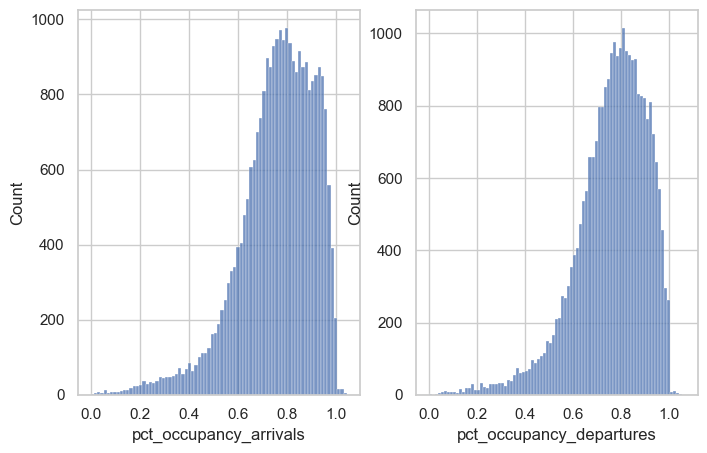

In [581]:
_, ax = plt.subplots(1, 2, figsize=(8, 5))
sns.histplot(data=merged_df, x='pct_occupancy_arrivals', ax=ax[0])
sns.histplot(data=merged_df, x='pct_occupancy_departures', ax=ax[1])


In [562]:
merged_df.head(10)

,year,month,domestic_airpot,international_airport,country_code,continent_name,num_passangers_arrivals,num_passangers_departures,total_capacity_arrivals,total_capacity_departures,num_flights_arrivals,num_flights_departures
0,2012,03,IE_EICK,BE_EBBR,Belgium,Europe,271.0,307.0,522.0,522.0,3.0,3.0
1,2012,04,IE_EICK,BE_EBBR,Belgium,Europe,1346.0,1321.0,2262.0,2262.0,13.0,13.0
2,2012,05,IE_EICK,BE_EBBR,Belgium,Europe,1377.0,1344.0,2262.0,2262.0,13.0,13.0
3,2012,06,IE_EICK,BE_EBBR,Belgium,Europe,1082.0,1152.0,2262.0,2262.0,13.0,13.0
4,2012,07,IE_EICK,BE_EBBR,Belgium,Europe,1550.0,1383.0,2262.0,2262.0,13.0,13.0
5,2012,08,IE_EICK,BE_EBBR,Belgium,Europe,1456.0,1551.0,2436.0,2436.0,14.0,14.0
6,2012,09,IE_EICK,BE_EBBR,Belgium,Europe,1004.0,968.0,2088.0,2088.0,12.0,12.0
7,2012,10,IE_EICK,BE_EBBR,Belgium,Europe,1515.0,1361.0,2610.0,2610.0,15.0,15.0
8,2012,11,IE_EICK,BE_EBBR,Belgium,Europe,1345.0,1619.0,2784.0,2784.0,16.0,16.0
9,2012,12,IE_EICK,BE_EBBR,Belgium,Europe,1597.0,1305.0,2784.0,2784.0,16.0,16.0


In [594]:
lower_quantile, upper_quantile = merged_df.num_passangers_arrivals.quantile([.25, .75])

upper = merged_df.loc[(merged_df['num_passangers_arrivals'] > upper_quantile)]
upper.head()

,year,month,domestic_airpot,international_airport,country_code,continent_name,num_passangers_arrivals,num_passangers_departures,total_capacity_arrivals,total_capacity_departures,num_flights_arrivals,num_flights_departures,pct_occupancy_arrival,pct_occupancy_departures,pct_occupancy_arrivals
1107,2012,07,IE_EICK,ES_LEMG,Spain,Europe,9290.0,9446.0,9855.0,10038.0,55.0,56.0,0.942669,0.941024,0.942669
1167,2017,07,IE_EICK,ES_LEMG,Spain,Europe,9468.0,9451.0,10611.0,10611.0,59.0,59.0,0.892282,0.890679,0.892282
1168,2017,08,IE_EICK,ES_LEMG,Spain,Europe,9201.0,8051.0,10248.0,10248.0,57.0,57.0,0.897834,0.785617,0.897834
1178,2018,06,IE_EICK,ES_LEMG,Spain,Europe,9710.0,10382.0,10755.0,10755.0,60.0,60.0,0.902836,0.965318,0.902836
1179,2018,07,IE_EICK,ES_LEMG,Spain,Europe,9753.0,9529.0,10755.0,10755.0,60.0,60.0,0.906834,0.886007,0.906834


In [588]:
merged_df['country_code'].value_counts()
upper_quantile_df['country_code'].value_counts()

country_code
United Kingdom of Great Britain & Northern Ireland    9845
Spain                                                 4759
Germany                                               1716
Poland                                                1694
France                                                1494
Italy                                                 1353
Portugal                                               996
Ireland                                                849
Netherlands                                            675
Belgium                                                524
Switzerland                                            428
Lithuania                                              401
Czech Republic                                         297
Hungary                                                266
Denmark                                                245
Austria                                                232
Latvia                                     

country_code
Spain    5
Name: count, dtype: int64

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_43312/3767855904.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = a.set_xticklabels(a.get_xticklabels(), rotation=35)


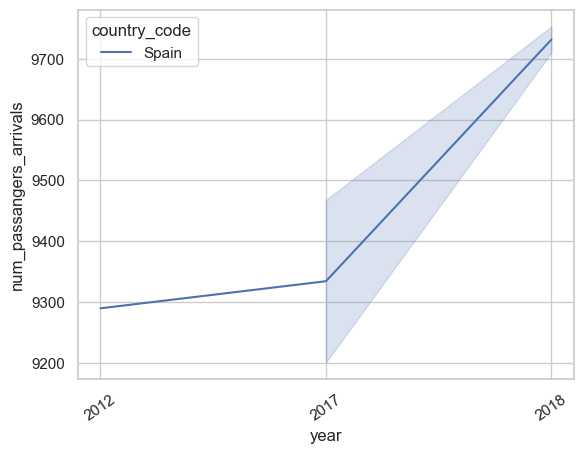

In [590]:
a = sns.lineplot(data=merged_df, x='year', y='num_passangers_arrivals', hue='country_code')
_ = a.set_xticklabels(a.get_xticklabels(), rotation=35)

## Machine Learning <a class="anchor" id="ml"></a>


In [ ]:
import numpy as np
from sklearn.preprocessing import scale, StandardScaler

# Generating example data with different scales
data = np.array([[1.0, 20.0, 300.0],
                 [4.0, 50.0, 600.0],
                 [7.0, 80.0, 900.0]])

print("Original data:\n", data)

# Method 1: Scaling using the scale function
scaled_data = scale(data)
print("\nScaled data using scale function:\n", scaled_data)

# Method 2: Using StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)
print("\nStandardized data using StandardScaler:\n", standardized_data)

In [ ]:
# Model building

# instantiate an object of class SVC()
# note that we are using cost C=1
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

print(y_pred)